In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from matplotlib.pylab import rcParams
pd.set_option("display.max_rows", 101)
pd.set_option("display.max_columns", 101)
%matplotlib inline

In [2]:
df=pd.read_csv("air_visit_data.csv",parse_dates=["visit_date"])

In [3]:
#元のデータは欠損があるため日時のベースを作成
basedate=pd.DataFrame(list(pd.date_range('2016-05-01', '2016-08-20')))
basedate.columns=["visit_date"]

In [4]:
#店舗を指定、日時を限定
store1=df[df["air_store_id"]=="air_e55abd740f93ecc4"]
store1=store1[(store1["visit_date"]>="2016-05") & (store1["visit_date"]<="2016-08-20")]
store2=df[df["air_store_id"]=="air_1653a6c513865af3"]
store2=store2[(store2["visit_date"]>="2016-05") & (store2["visit_date"]<="2016-08-20")]

In [5]:
store1.rename(columns={"visitors":"visitors_store1"},inplace=True)
store2.rename(columns={"visitors":"visitors_store2"},inplace=True)
data=pd.merge(basedate,store1[["visit_date","visitors_store1"]],on="visit_date",how="left")
data=pd.merge(data,store2[["visit_date","visitors_store2"]],on="visit_date",how="left")
data=data.interpolate() #欠損値を線形補間
data=data.set_index("visit_date")

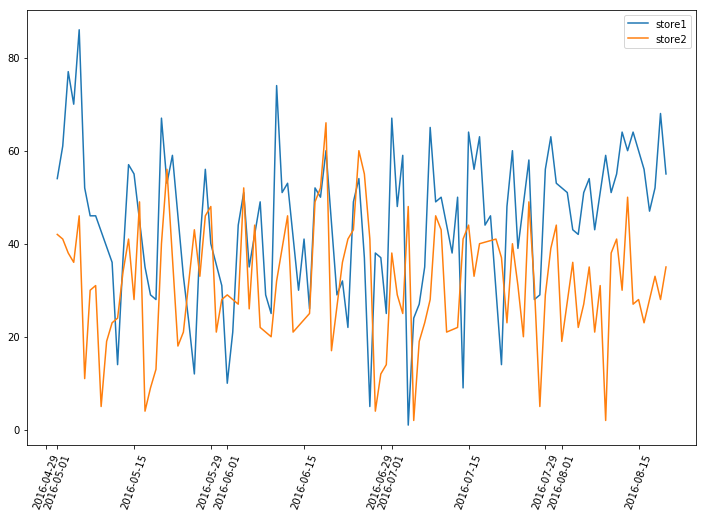

In [6]:
plt.figure(figsize=(12,8))
plt.plot(data["visitors_store1"],label="store1")
plt.plot(data["visitors_store2"],label="store2")
#plt.plot(data["visit_date"],data["visitors_store1"],label="store1")
#plt.plot(data["visit_date"],data["visitors_store2"],label="store2")
plt.xticks(rotation=70)
plt.legend()
plt.show()

In [7]:
data.head()

,visitors_store1,visitors_store2
visit_date,,
2016-05-01,54.0,42.0
2016-05-02,61.0,41.0
2016-05-03,77.0,38.0
2016-05-04,70.0,36.0
2016-05-05,86.0,46.0


In [8]:
from causalimpact import CausalImpact
pre_period = ['2016-05-01', '2016-08-10']
post_period = ['2016-08-11', '2016-08-20']
ci = CausalImpact(data, pre_period, post_period,nseasons=[{'period': 7}],trend=True)

/Users/rmizuta/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/rmizuta/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/rmizuta/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]


In [9]:
print(ci.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    58.1               581.0
Prediction (s.d.)         44.4 (4.5)         444.1 (44.5)
95% CI                    [35.5, 53.0]       [355.1, 529.6]

Absolute effect (s.d.)    13.7 (4.5)         136.9 (44.5)
95% CI                    [5.1, 22.6]        [51.4, 225.9]

Relative effect (s.d.)    30.8% (10.0%)      30.8% (10.0%)
95% CI                    [11.6%, 50.9%]     [11.6%, 50.9%]

Posterior tail-area probability p: 0.001
Posterior prob. of a causal effect: 99.90%

For more details run the command: print(impact.summary('report'))


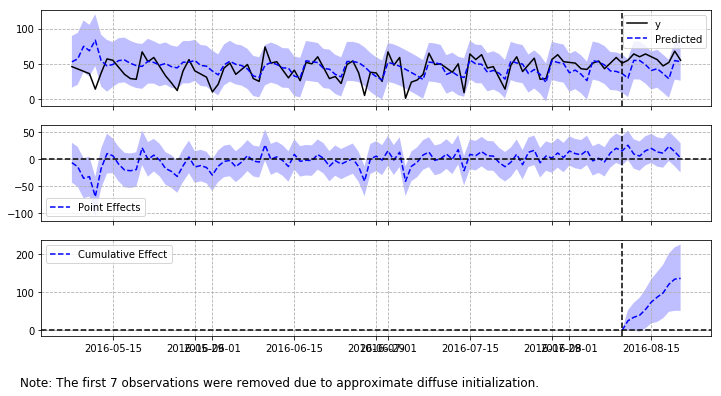

In [10]:
fig=ci.plot(figsize=(12, 6))

In [11]:
#状態空間モデルの結果
ci.trained_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               Unobserved Components Results                                
============================================================================================
Dep. Variable:                      visitors_store1   No. Observations:                  102
Model:                                  local level   Log Likelihood                -128.121
                   + stochastic freq_seasonal(7(3))   AIC                            264.243
Date:                              Thu, 09 May 2019   BIC                            274.458
Time:                                      20:52:21   HQIC                           268.370
Sample:                                  05-01-2016                                         
                                       - 08-10-2016                                         
Covariance Type:                                opg                                         
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
sigma2.irregular              0.7075      0.102      6.950      0.000       0.508       0.907
sigma2.level                  0.0001      0.001      0.130      0.897      -0.002       0.002
sigma2.freq_seasonal_7(3)  1.438e-11      0.001   1.52e-08      1.000      -0.002       0.002
beta.visitors_store2          0.0925      0.102      0.905      0.365      -0.108       0.293
===================================================================================
Ljung-Box (Q):                       59.42   Jarque-Bera (JB):                16.53
Prob(Q):                              0.02   Prob(JB):                         0.00
Heteroskedasticity (H):               0.41   Skew:                            -0.82
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [12]:
#単系列
pre_period = ['2016-05-01', '2016-08-10']
post_period = ['2016-08-11', '2016-08-20']
ci = CausalImpact(data.iloc[:,0], pre_period, post_period,nseasons=[{'period': 7}])

/Users/rmizuta/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/rmizuta/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/statsmodels/tsa/statespace/structural.py:1788: ValueWarning: Exogenous array provided to predict, but additional data not required. `exog` argument ignored.
  ' required. `exog` argument ignored.', ValueWarning)


In [13]:
print(ci.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    58.1               581.0
Prediction (s.d.)         44.4 (4.5)         443.8 (44.6)
95% CI                    [36.0, 53.4]       [359.6, 534.3]

Absolute effect (s.d.)    13.7 (4.5)         137.2 (44.6)
95% CI                    [4.7, 22.1]        [46.7, 221.4]

Relative effect (s.d.)    30.9% (10.1%)      30.9% (10.1%)
95% CI                    [10.5%, 49.9%]     [10.5%, 49.9%]

Posterior tail-area probability p: 0.004
Posterior prob. of a causal effect: 99.60%

For more details run the command: print(impact.summary('report'))


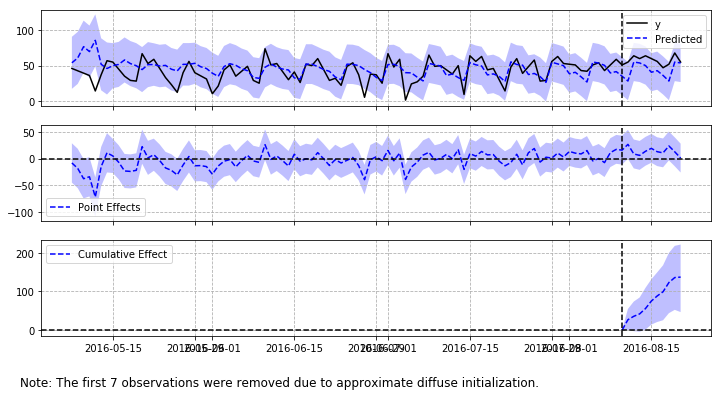

In [14]:
ci.plot(figsize=(12, 6))